# Another compression method

In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-21 16:36:19.343319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 16:36:19.359584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 16:36:19.364349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 16:36:19.378860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 16:36:20.569606: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [2]:
compressed_dv_sims = np.load('../compression_NN/output/compressed_dv_semi_ae_v4.npy')
compressed_dv_labels = np.load('../compression_NN/output/pars_LFI.npy')

compressed_dv_fid  = np.load('../compression_NN/output/dv_compressed_fid_ae_v4.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [3]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [4]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=4))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test',\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [5]:
def TESTTEST(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels):
    gd_samples = []


    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=50, num_transforms=4))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

    return samples

In [6]:
gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels)

/tmp/ipykernel_1244524/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 78 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_1244524/3272933811.py:13: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 95 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


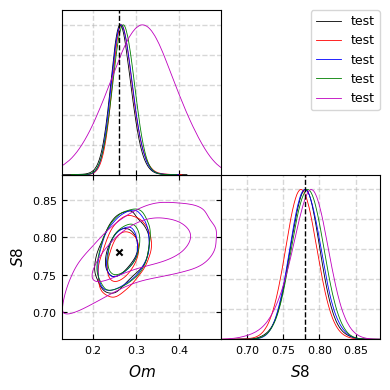

In [7]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples_list, filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [8]:
cov_mat_list = []

for i in range(len(gd_samples_list)):
    cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)

In [9]:
FoM_list = []
for i in range(len(gd_samples_list)):
    FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
    print(f'FoM in test {i} is {FoM_list[i]}')
    
FoM_list = np.array(FoM_list)

print('mean FoM is ', np.mean(FoM_list))

FoM in test 0 is 2012.2774421543154
FoM in test 1 is 2007.3602136700868
FoM in test 2 is 2020.7305107041707
FoM in test 3 is 1935.2010090849508
FoM in test 4 is 603.0044706350352
mean FoM is  1715.7147292497116
